# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import svm, metrics
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve
from sklearn.base import BaseEstimator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC

##### 1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).

In [2]:
class PegasosSVM(BaseEstimator):
    # Inherit from sklearn's BaseEstimator so that we can use it like any other sklearn model.

    def __init__(self, lambda_=1.0, max_iter=10000):
        """The param `max_iter` represents T in the Pagasos algorithm."""
        self.lambda_ = lambda_
        self.max_iter = max_iter
        self.w = None  # As row vector.

    def fit(self, X, y):
        X = self._pad(X)
        y = self._scale_y(y)

        self.w = np.zeros((1, X.shape[1]))
        for t in range(1, self.max_iter + 1):
            sample_idx = np.random.randint(0, len(y), 1)
            step_size = 1.0 / (self.lambda_ * t)
            margin = y[sample_idx] * self._decision_function(X[sample_idx])
            self.w *= 1 - (step_size * self.lambda_)
            if margin < 1:
                self.w += step_size * y[sample_idx] * X[sample_idx]

    def predict(self, X):
        X = self._pad(X)
        # Get distance from hyperplane.
        distance = self._decision_function(X).flatten()
        y = np.zeros(X.shape[0], dtype=int)
        # The prediction is positive (1) if on the positive side of hyperplane.
        y[distance >= 0] = 1
        return y

    def decision_function(self, X):
        X = self._pad(X)
        return self._decision_function(X)

    def _decision_function(self, X):
        """Returns distance between hyperplane defined by self.w and each sample in X."""
        return np.dot(X, self.w.T)

    def _pad(self, X):
        """Pad X with a first column of 1s so that the first element of w can represent the intercept."""
        return np.pad(X, ((0,0), (1,0)), constant_values=1)

    def _scale_y(self, y):
        """Convert y from {0, 1} to {-1, +1}."""
        y_scaled = y.copy()
        y_scaled[y==0] = -1
        return y_scaled

##### 2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [3]:
# Load Data
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

dataset = load_breast_cancer()
X = dataset.data # The data matrix of shape (569, 30). If as_frame=True, data will be a pandas DataFrame.
y = dataset.target # The classification target. If as_frame=True, target will be a pandas Series.

feature_names = dataset.feature_names # The names of the dataset columns (30 features).
target_names = dataset.target_names # The names of target classes ('malignant', 'benign').

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [4]:
# Using PegasosSVM
lambda_ = 1.0
my_svm = Pipeline([
    ("scale", StandardScaler()),
    ("cls", PegasosSVM(lambda_=lambda_))
])

cv_auc = cross_val_score(my_svm, X_train, y_train, cv=5, scoring="roc_auc")
print(f"CV AUC: mean: {cv_auc.mean():.4f}, std: {cv_auc.std():.4f}")
my_svm.fit(X_train, y_train)
y_pred = my_svm.predict(X_test)
print(f"Test AUC: {metrics.roc_auc_score(y_test, y_pred):.4f}")
w = my_svm.named_steps["cls"].w.flatten()
print(f"Intercept:", w[0])
print(f"Coefficients:", w[1:])

CV AUC: mean: 0.9907, std: 0.0099
Test AUC: 0.9306
Intercept: 0.12349999999999994
Coefficients: [-0.10824047 -0.07137056 -0.10807551 -0.10723757 -0.04505844 -0.05658107
 -0.0940232  -0.12365245 -0.05302772  0.03182745 -0.1015358   0.0048731
 -0.08797948 -0.08740652  0.01033737  0.01928946  0.03422943 -0.00553644
 -0.01341038  0.03905912 -0.13130976 -0.09232161 -0.12708726 -0.12272863
 -0.07926284 -0.08102856 -0.08879453 -0.12663414 -0.10385112 -0.05544121]


In [5]:
# Using sklearn's LinearSVC
C = 1.0 / (lambda_ * len(y_train))
sklearn_svm = Pipeline([
    ("scale", StandardScaler()),
    ("cls", LinearSVC(C=C, loss="hinge"))
])

cv_auc = cross_val_score(sklearn_svm, X_train, y_train, cv=5, scoring="roc_auc")
print(f"CV AUC: mean: {cv_auc.mean():.4f}, std: {cv_auc.std():.4f}")
sklearn_svm.fit(X_train, y_train)
y_pred = sklearn_svm.predict(X_test)
print(f"Test AUC: {metrics.roc_auc_score(y_test, y_pred):.4f}")
print(f"Intercept:", sklearn_svm.named_steps["cls"].intercept_[0])
print(f"Coefficients:", sklearn_svm.named_steps["cls"].coef_.flatten())

CV AUC: mean: 0.9904, std: 0.0105
Test AUC: 0.9306
Intercept: 0.129271826107061
Coefficients: [-0.10838533 -0.07140371 -0.10845898 -0.10788661 -0.0402337  -0.05775171
 -0.09506152 -0.12305434 -0.05312978  0.03319617 -0.1000015   0.00664098
 -0.08914485 -0.08704085  0.01367764  0.01675651  0.03518553 -0.00685374
 -0.01294178  0.04600119 -0.13118315 -0.09171637 -0.12726458 -0.12315625
 -0.07509533 -0.08316991 -0.09212346 -0.12830394 -0.10198352 -0.0560835 ]


##### 3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 

In [6]:
def plot_log_validation_curve(param_range, train_scores, test_scores):
    # Modified from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 8))
    plt.title("Validation Curve")
    plt.xlabel("Param")
    plt.ylabel("Score")
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")

Text(0.5, 0, '$\\lambda$')

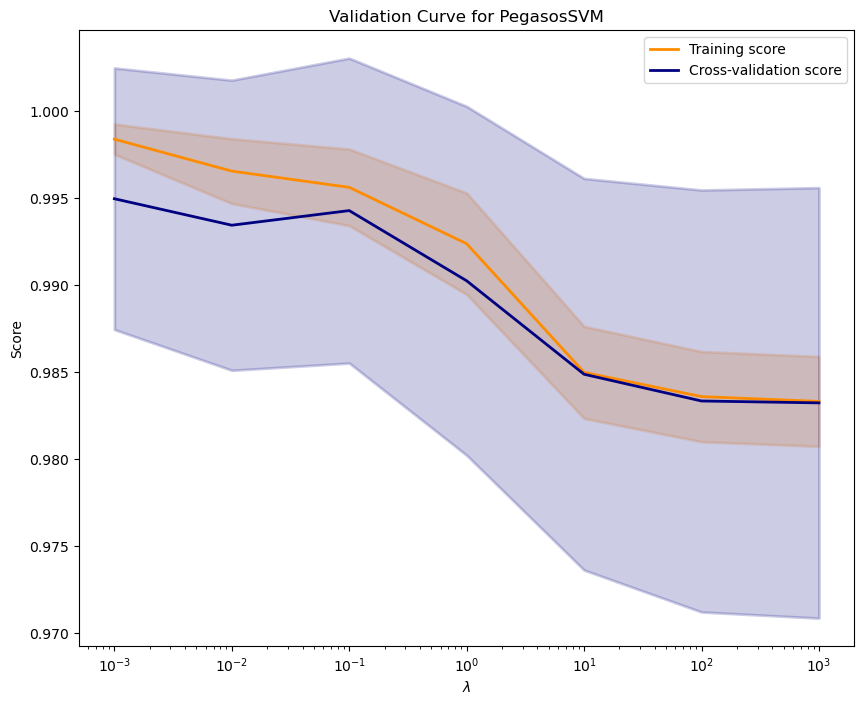

In [7]:
# Sweep lambda for PegasosSVM
param_sweep = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(my_svm, X_train, y_train, param_name="cls__lambda_", param_range=param_sweep, cv=5, scoring="roc_auc")
plot_log_validation_curve(param_sweep, train_scores, test_scores)
plt.title("Validation Curve for PegasosSVM")
plt.xlabel(r"$\lambda$")

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\svm\_base.py:1225: Conv

Text(0.5, 0, 'C')

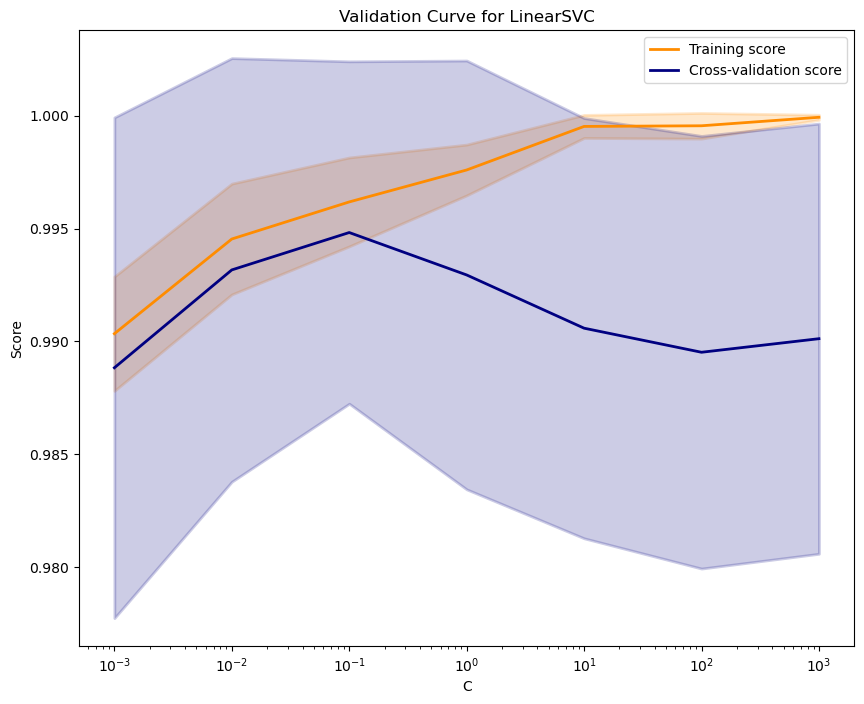

In [8]:
# Sweep C for LinearSVC
param_sweep = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(sklearn_svm, X_train, y_train, param_name="cls__C", param_range=param_sweep, cv=5, scoring="roc_auc")
plot_log_validation_curve(param_sweep, train_scores, test_scores)
plt.title("Validation Curve for LinearSVC")
plt.xlabel("C")

In [9]:
# Compare results on test set using using best hyper parameters.
lambda_ = 0.01
my_svm = Pipeline([
    ("scale", StandardScaler()),
    ("cls", PegasosSVM(lambda_=lambda_))
])
my_svm.fit(X_train, y_train)
print(f"PegasosSVM(lambda={lambda_}):")
print(f"    Train AUC: {metrics.roc_auc_score(y_train, my_svm.predict(X_train)):.4f}")
print(f"    Test AUC: {metrics.roc_auc_score(y_test, my_svm.predict(X_test)):.4f}")
print()

C = 0.1
sklearn_svm = Pipeline([
    ("scale", StandardScaler()),
    ("cls", LinearSVC(C=C, loss="hinge"))
])
sklearn_svm.fit(X_train, y_train)
print(f"LinearSVC(C={C}):")
print(f"    Train AUC: {metrics.roc_auc_score(y_train, sklearn_svm.predict(X_train)):.4f}")
print(f"    Test AUC: {metrics.roc_auc_score(y_test, sklearn_svm.predict(X_test)):.4f}")

PegasosSVM(lambda=0.01):
    Train AUC: 0.9824
    Test AUC: 0.9645

LinearSVC(C=0.1):
    Train AUC: 0.9855
    Test AUC: 0.9606


##### 4. Analyze the learning curve (performance as function of training size)

In [10]:
def plot_learning_curve(trains_sizes_abs, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 8))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    lw = 2
    plt.plot(
        trains_sizes_abs, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        trains_sizes_abs,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        trains_sizes_abs, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        trains_sizes_abs,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")

Text(0.5, 1.0, 'Learning Curve for PegasosSVM')

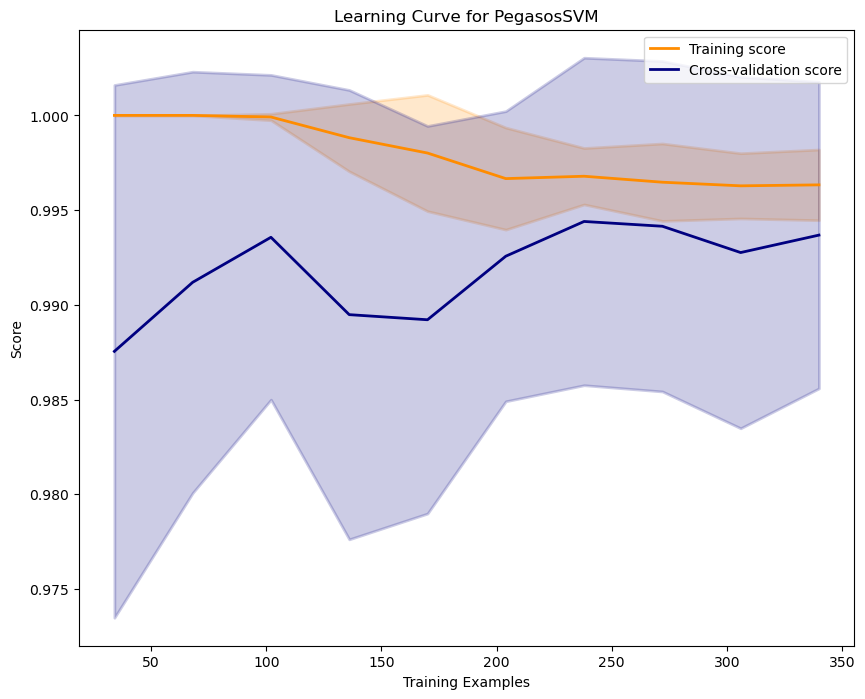

In [11]:
plot_learning_curve(*learning_curve(my_svm, X_train, y_train, train_sizes=np.arange(0.1, 1.1, 0.1), cv=5, scoring="roc_auc"))
plt.title("Learning Curve for PegasosSVM")

Text(0.5, 1.0, 'Learning Curve for LinearSVC')

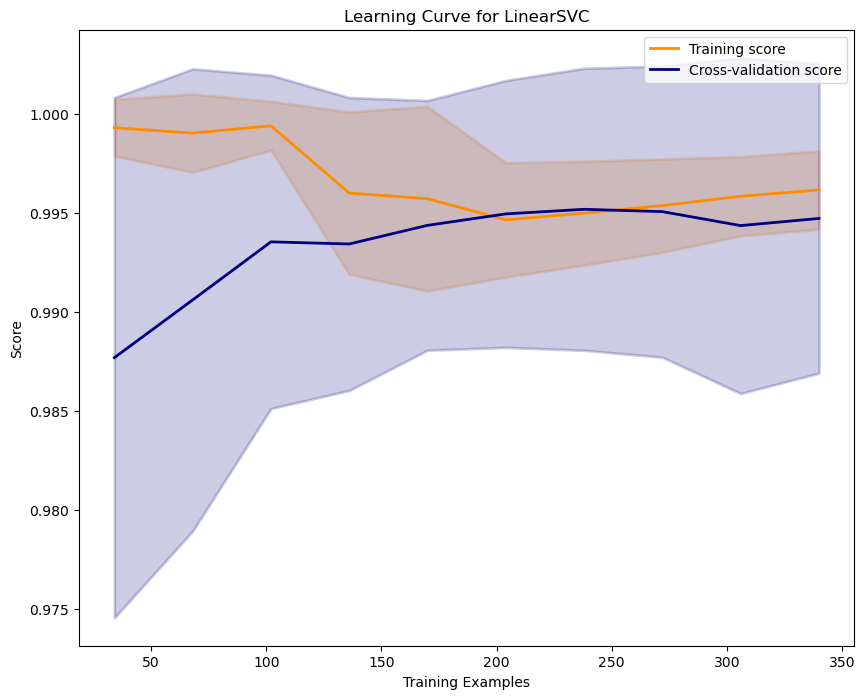

In [12]:
plot_learning_curve(*learning_curve(sklearn_svm, X_train, y_train, train_sizes=np.arange(0.1, 1.1, 0.1), cv=5, scoring="roc_auc"))
plt.title("Learning Curve for LinearSVC")

## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`. 
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.


## Answer #

In [13]:
# THe function make_data generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

##### 1. For `d=10` and `d=2` plot the scatter plot of the data.

Text(0.5, 1.0, 'd = 10')

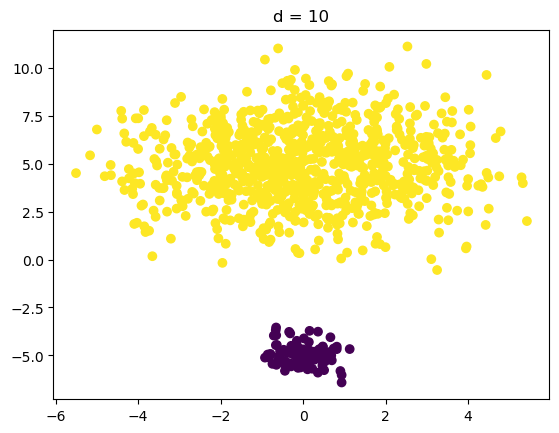

In [14]:
d = 10
X_d10, y_d10 = make_data(d)
plt.scatter(X_d10[:,0], X_d10[:,1], c=y_d10)
plt.title(f"d = {d}")

Text(0.5, 1.0, 'd = 2')

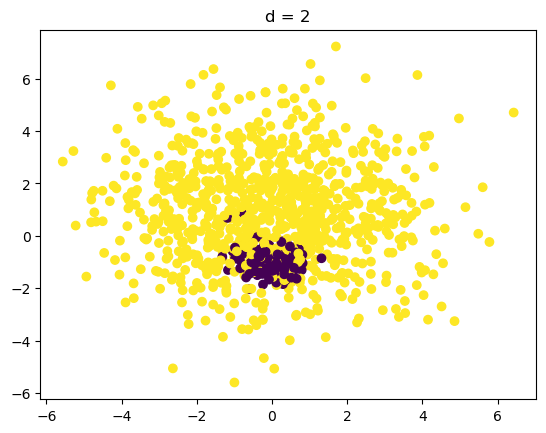

In [15]:
d = 2
X_d2, y_d2 = make_data(d)
plt.scatter(X_d2[:,0], X_d2[:,1], c=y_d2)
plt.title(f"d = {d}")

##### Where would you think the SVM hyperplane will lie?

- For d=10, the hyperplane should be nearly horizontal at roughly x2 = -2.5
- For d=2, there is no hyperplane which will separate the 2 classes, but a best attempt is probably nearly horizontal just below x2 = 0

##### 2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

In [16]:
def plot_feature_space(d, X, y, classifier):
    classifier.fit(X, y)

    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1], c=y)

    # Include accuracy metrics in title.
    y_pred = classifier.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y, y_pred)
    plt.title(f"d = {d} (acc={acc:.1%}, bal_acc={bal_acc:.1%})")

    # Plot hyperplane.
    w = classifier.named_steps["cls"].coef_.flatten()
    b = classifier.named_steps["cls"].intercept_[0]
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = (-1.0 / w[1]) * ((x * w[0]) + b)
    plt.plot(x, y)

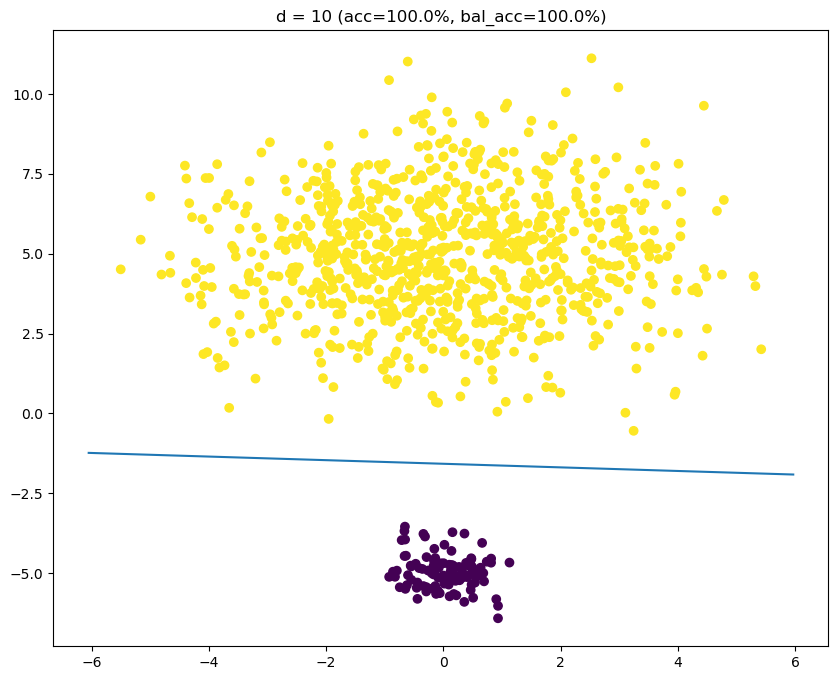

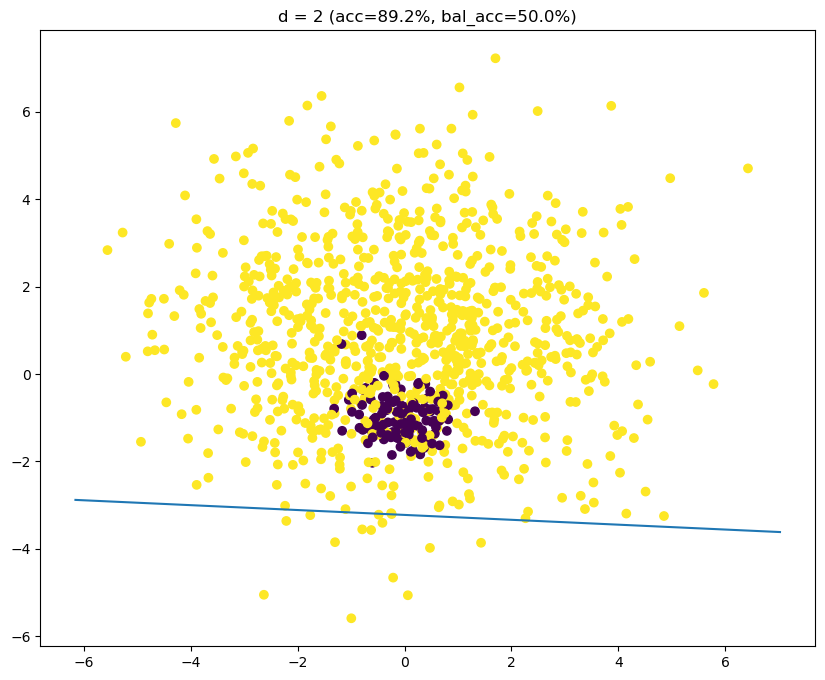

In [17]:
svm = Pipeline([
    ("preproc", StandardScaler()),
    ("cls", LinearSVC())
])
plot_feature_space(10, X_d10, y_d10, svm)
plot_feature_space(2, X_d2, y_d2, svm)

##### 3. repeat the experiment but now set the `class_weight` to be `balanced`. 

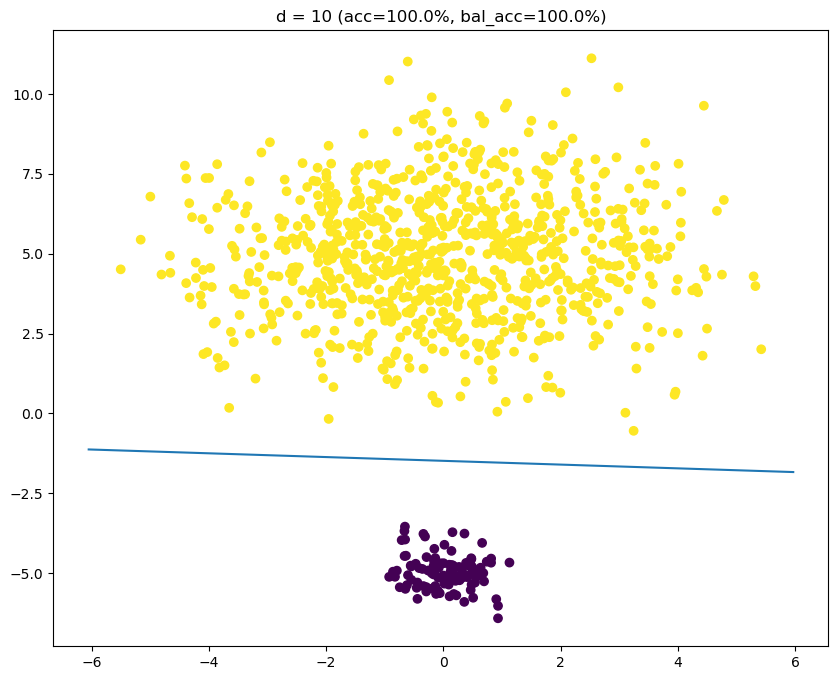

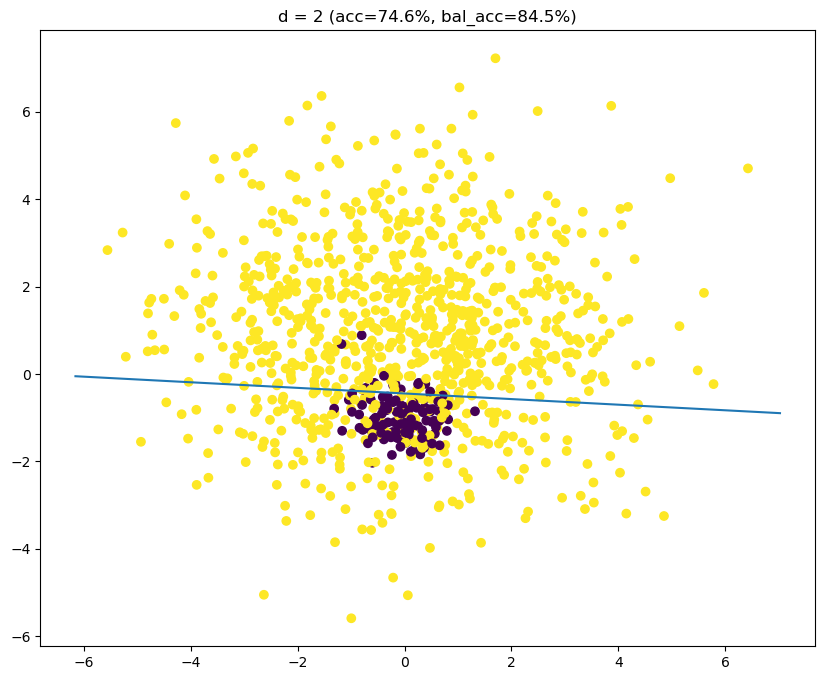

In [18]:
svm = Pipeline([
    ("preproc", StandardScaler()),
    ("cls", LinearSVC(class_weight="balanced"))
])
plot_feature_space(10, X_d10, y_d10, svm)
plot_feature_space(2, X_d2, y_d2, svm)

##### Explain what was the problem and how changing class weight solved it.

- Without the class weights, the classifier chose a hyperplane which did not separate the classes at all and simply accepted the penalty associated with misclassifying all of the minority class samples since there were so few of them. This resulted in a high (unbalanced) accuracy score despite the fact that all instances of the minority class were misclassified.
- By weighting the samples inversely proportial to their representation in the dataset, significantly more weight was placed on the minority class samples and thus it no longer made sense to take the penalty for misclassifying all of them. The result is a hyperplane close to what I had recommended by looking at the data visually.

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [19]:
dataset = load_breast_cancer()
X = dataset.data # The data matrix of shape (569, 30). If as_frame=True, data will be a pandas DataFrame.
y = dataset.target # The classification target. If as_frame=True, target will be a pandas Series.

feature_names = dataset.feature_names # The names of the dataset columns (30 features).
target_names = dataset.target_names # The names of target classes ('malignant', 'benign').

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
len(y_test)

57

In [21]:
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', LinearSVC(max_iter=1e6))
])

In [22]:
# Report accuracy of default model.
model.fit(X_train, y_train)
print("Default LinearSVC model (C=1, loss=squared_hinge, multi_class=ovr):")
print(f"    Training accuracy: {metrics.accuracy_score(y_train, model.predict(X_train)):.2%}")
print(f"    Test accuracy: {metrics.accuracy_score(y_test, model.predict(X_test)):.2%}")

Default LinearSVC model (C=1, loss=squared_hinge, multi_class=ovr):
    Training accuracy: 99.02%
    Test accuracy: 96.49%


In [23]:
# Report accuracy of tuned model
parameters = {
    'svc__C':np.logspace(-3,3,10), 
    'svc__multi_class':['ovr', 'crammer_singer'],
    'svc__loss':['hinge', 'squared_hinge']
}
grid = GridSearchCV(model, cv=3, param_grid=parameters)
grid.fit(X_train, y_train)
print(f"Best tuned LinearSVC model (C={grid.best_params_['svc__C']:.4f}, loss={grid.best_params_['svc__loss']}, multi_class={grid.best_params_['svc__multi_class']}):")
print(f"    Training accuracy: {metrics.accuracy_score(y_train, grid.predict(X_train)):.2%}")
print(f"    Test accuracy: {metrics.accuracy_score(y_test, grid.predict(X_test)):.2%}")

Best tuned LinearSVC model (C=0.0046, loss=hinge, multi_class=crammer_singer):
    Training accuracy: 98.24%
    Test accuracy: 98.25%


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [24]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

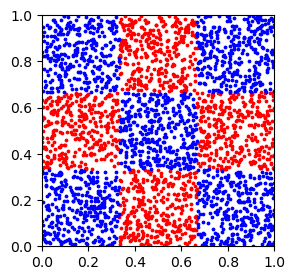

In [25]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [26]:
# Generate data
X_train, y_train = checkerboard(1000)
X_test, y_test = checkerboard(200)

In [27]:
def plot_checkerboard(X, y, model_pipeline = None):
    """If model_pipeline is specified, also mark support vectors with red plus."""
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=y)

    if model_pipeline:
        # Undo the scaling of the support vectors so that they're on the same scale as the input data.
        scaler = model_pipeline.named_steps["scaler"]
        scaled_support_vectors = model_pipeline.named_steps["svc"].support_vectors_
        support_vectors = scaler.inverse_transform(scaled_support_vectors)

        plt.scatter(support_vectors[:,0], support_vectors[:,1], color="red", marker="+")

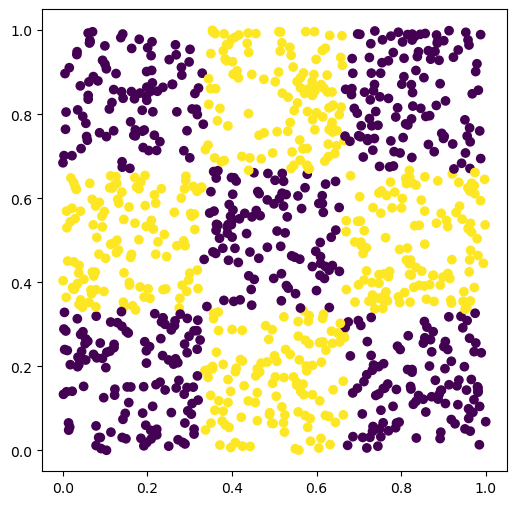

In [28]:
plot_checkerboard(X_train, y_train)

In [29]:
# Find best polynomial kernel model.
poly_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(kernel="poly"))
])
parameters = {
    'svc__C':np.logspace(-3, 3, 7), 
    'svc__degree':list(range(2, 10)),
}
poly_grid = GridSearchCV(poly_model, cv=3, param_grid=parameters, n_jobs=-1)
poly_grid.fit(X_train, y_train)
best_params = poly_grid.best_params_
print(f"Best tuned SVC model with poly kernel (C={best_params['svc__C']:.4f}, degree={best_params['svc__degree']}):")
print(f"    Training accuracy: {metrics.accuracy_score(y_train, poly_grid.predict(X_train)):.2%}")
print(f"    Test accuracy: {metrics.accuracy_score(y_test, poly_grid.predict(X_test)):.2%}")

Best tuned SVC model with poly kernel (C=1.0000, degree=4):
    Training accuracy: 87.60%
    Test accuracy: 83.00%


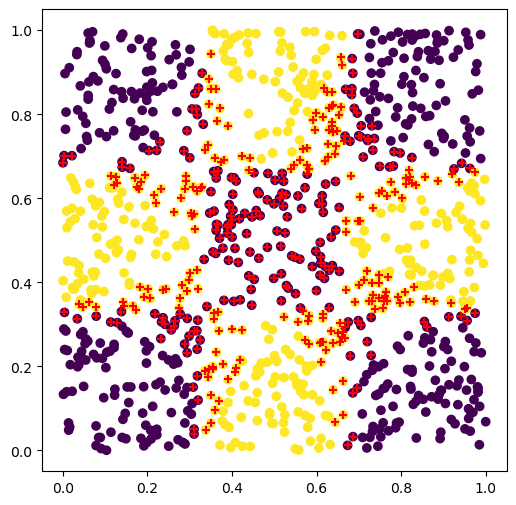

In [30]:
plot_checkerboard(X_train, y_train, poly_grid.best_estimator_)

In [31]:
# Find best RBF kernel model.
rbf_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(kernel="rbf"))
])
parameters = {
    'svc__C':np.logspace(-3, 4, 8), 
    'svc__gamma':["scale", "auto"],
}
rbf_grid = GridSearchCV(rbf_model, cv=3, param_grid=parameters, n_jobs=-1)
rbf_grid.fit(X_train, y_train)
best_params = rbf_grid.best_params_
print(f"Best tuned SVC model with RBF kernel (C={best_params['svc__C']:.4f}, gamma={best_params['svc__gamma']}):")
print(f"    Training accuracy: {metrics.accuracy_score(y_train, rbf_grid.predict(X_train)):.2%}")
print(f"    Test accuracy: {metrics.accuracy_score(y_test, rbf_grid.predict(X_test)):.2%}")

Best tuned SVC model with RBF kernel (C=10000.0000, gamma=scale):
    Training accuracy: 99.60%
    Test accuracy: 99.00%


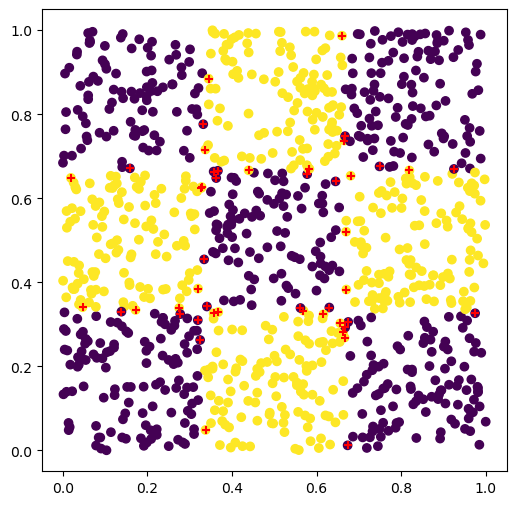

In [32]:
plot_checkerboard(X_train, y_train, rbf_grid.best_estimator_)

### Which model would you choose to use polynomial kernel vs. RBF?
- RBF model since it was able to learn the decision boundaries (as identified by the support vectors) and has a much higher training and test accuracy.

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

